# SW중심대학 공동 AI 경진대회
### 팀명: 한림대학교

안녕하세요, 한림대학교 팀입니다 :) 팀명 그대로 한림대학교 학부생 동기들끼리 구성된 팀입니다. 

저희는 기본적인 EDA와 더불어 이상치와 결측치 Imputer 보간, 모델 탐색 및 앙상블 기법을 적용하였습니다. 튜닝을 하면 할 수록, 전처리를 하면 할 수록 성능이 저하되어 최고점이었던 코드를 업로드합니다.

해당 코드는 기본적인 EDA만 포함되어있으며 자세한 EDA진행 및 시각화, 모델 튜닝 내역은 아래 링크를 접속
하여 확인해주시기 바랍니다.

[Github link](https://github.com/younghoonNa/Dacon_Prediction-of-Machiavellian-Tendency)
- 제출 코드
- EDA 시각화 코드
- Model Tuning 코드 (n_iterations 만 바꿔서 튜닝 진행)
- TabNet 코드 (CSV데이터를 딥러닝으로 돌려보고 싶으신 분들은 보시면 될 것 같습니다.) 성능 87%

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import numpy as np

# 데이터 불러오기

In [3]:
pd.set_option('display.max_columns', 500) # 모든 컬럼 생략없이 출력

↓csv파일을 불러오고 상관계수가 매우 낮은 'index', 'country' 컬럼을 제거합니다.

In [2]:
train = pd.read_csv("~/Dacon/SW중심대학 공동 AI 경진대회/competition_data/train.csv")
train = train.drop(['index', 'country'], axis=1) # index 컬럼 삭제 무의미한 데이터

test = pd.read_csv("~/Dacon/SW중심대학 공동 AI 경진대회/competition_data/test.csv")
test = test.drop(['index', 'country'], axis=1)

submission = pd.read_csv("~/Dacon/SW중심대학 공동 AI 경진대회/competition_data/sample_submission.csv")

# 데이터 확인

train셋 확인

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 68 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Q1            14959 non-null  float64
 1   Q2            14931 non-null  float64
 2   Q3            14950 non-null  float64
 3   Q4            14929 non-null  float64
 4   Q5            14962 non-null  float64
 5   Q6            14952 non-null  float64
 6   Q7            14924 non-null  float64
 7   Q8            14952 non-null  float64
 8   Q9            14944 non-null  float64
 9   Q10           14928 non-null  float64
 10  Q11           14941 non-null  float64
 11  Q12           14933 non-null  float64
 12  Q13           14960 non-null  float64
 13  Q14           14964 non-null  float64
 14  Q15           14955 non-null  float64
 15  Q16           14967 non-null  float64
 16  Q17           14963 non-null  float64
 17  Q18           14937 non-null  float64
 18  Q19           14947 non-nu

↑info 결과를 봤을때 결측치가 존재하고 모두 숫자형으로 이루어진 것을 확인하였습니다.

↓특징별 라벨 `nerdiness`와의 상관계수를 정렬하여 확인합니다.

In [8]:
pd.set_option('display.max_rows', 500)
abs(pd.DataFrame(train.corr())['nerdiness']).sort_values()

age             0.005443
testelapse      0.005550
introelapse     0.008319
familysize      0.011145
surveyelapse    0.011953
hand            0.013037
voted           0.013185
VCL9            0.016625
TIPI9           0.019146
VCL16           0.023411
TIPI2           0.023593
married         0.025577
VCL10           0.026029
gender          0.028255
education       0.028739
VCL7            0.031422
urban           0.032702
TIPI5           0.033092
VCL6            0.033286
TIPI8           0.033955
TIPI3           0.034856
TIPI7           0.035121
VCL1            0.035160
religion        0.036793
VCL15           0.039101
TIPI4           0.043339
VCL4            0.044750
VCL5            0.051207
engnat          0.055904
VCL11           0.056328
ASD             0.056631
VCL8            0.060814
VCL12           0.067186
orientation     0.068105
VCL2            0.073068
VCL14           0.087772
TIPI6           0.090820
TIPI10          0.095491
TIPI1           0.103434
VCL3            0.108972


↑↓ Q 질문의 상관계수가 매우 높게 나타났습니다.

In [9]:
train.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,engnat,age,hand,religion,orientation,voted,married,familysize,ASD,nerdiness
0,1.0,5.0,5.0,5.0,1.0,4.0,5.0,5.0,1.0,3.0,...,1.0,20,2.0,12.0,4.0,2.0,1.0,4.0,2.0,1
1,4.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0,3.0,3.0,...,1.0,49,1.0,2.0,1.0,1.0,2.0,4.0,2.0,1
2,4.0,5.0,5.0,4.0,3.0,5.0,5.0,5.0,4.0,4.0,...,2.0,43,1.0,2.0,2.0,2.0,3.0,4.0,2.0,1
3,4.0,4.0,4.0,2.0,4.0,3.0,3.0,5.0,3.0,4.0,...,1.0,17,2.0,1.0,1.0,2.0,1.0,2.0,2.0,1
4,4.0,4.0,4.0,4.0,3.0,3.0,4.0,2.0,3.0,4.0,...,2.0,18,2.0,12.0,1.0,2.0,1.0,1.0,2.0,0


## 결측치 확인

In [9]:
train.isna().sum()

Q1               41
Q2               69
Q3               50
Q4               71
Q5               38
Q6               48
Q7               76
Q8               48
Q9               56
Q10              72
Q11              59
Q12              67
Q13              40
Q14              36
Q15              45
Q16              33
Q17              37
Q18              63
Q19              53
Q20              45
Q21              39
Q22              38
Q23              50
Q24              61
Q25              44
Q26              68
introelapse       0
testelapse        0
surveyelapse      0
TIPI1            53
TIPI2            66
TIPI3            79
TIPI4            64
TIPI5            70
TIPI6            62
TIPI7            64
TIPI8            65
TIPI9            64
TIPI10           80
VCL1              0
VCL2              0
VCL3              0
VCL4              0
VCL5              0
VCL6              0
VCL7              0
VCL8              0
VCL9              0
VCL10             0
VCL11             0


↑결측치가 상당 수 보입니다. 저희는 이상치 처리 후에 같이 결측치를 처리하고자 합니다.

## 데이터 전처리 전 시각화

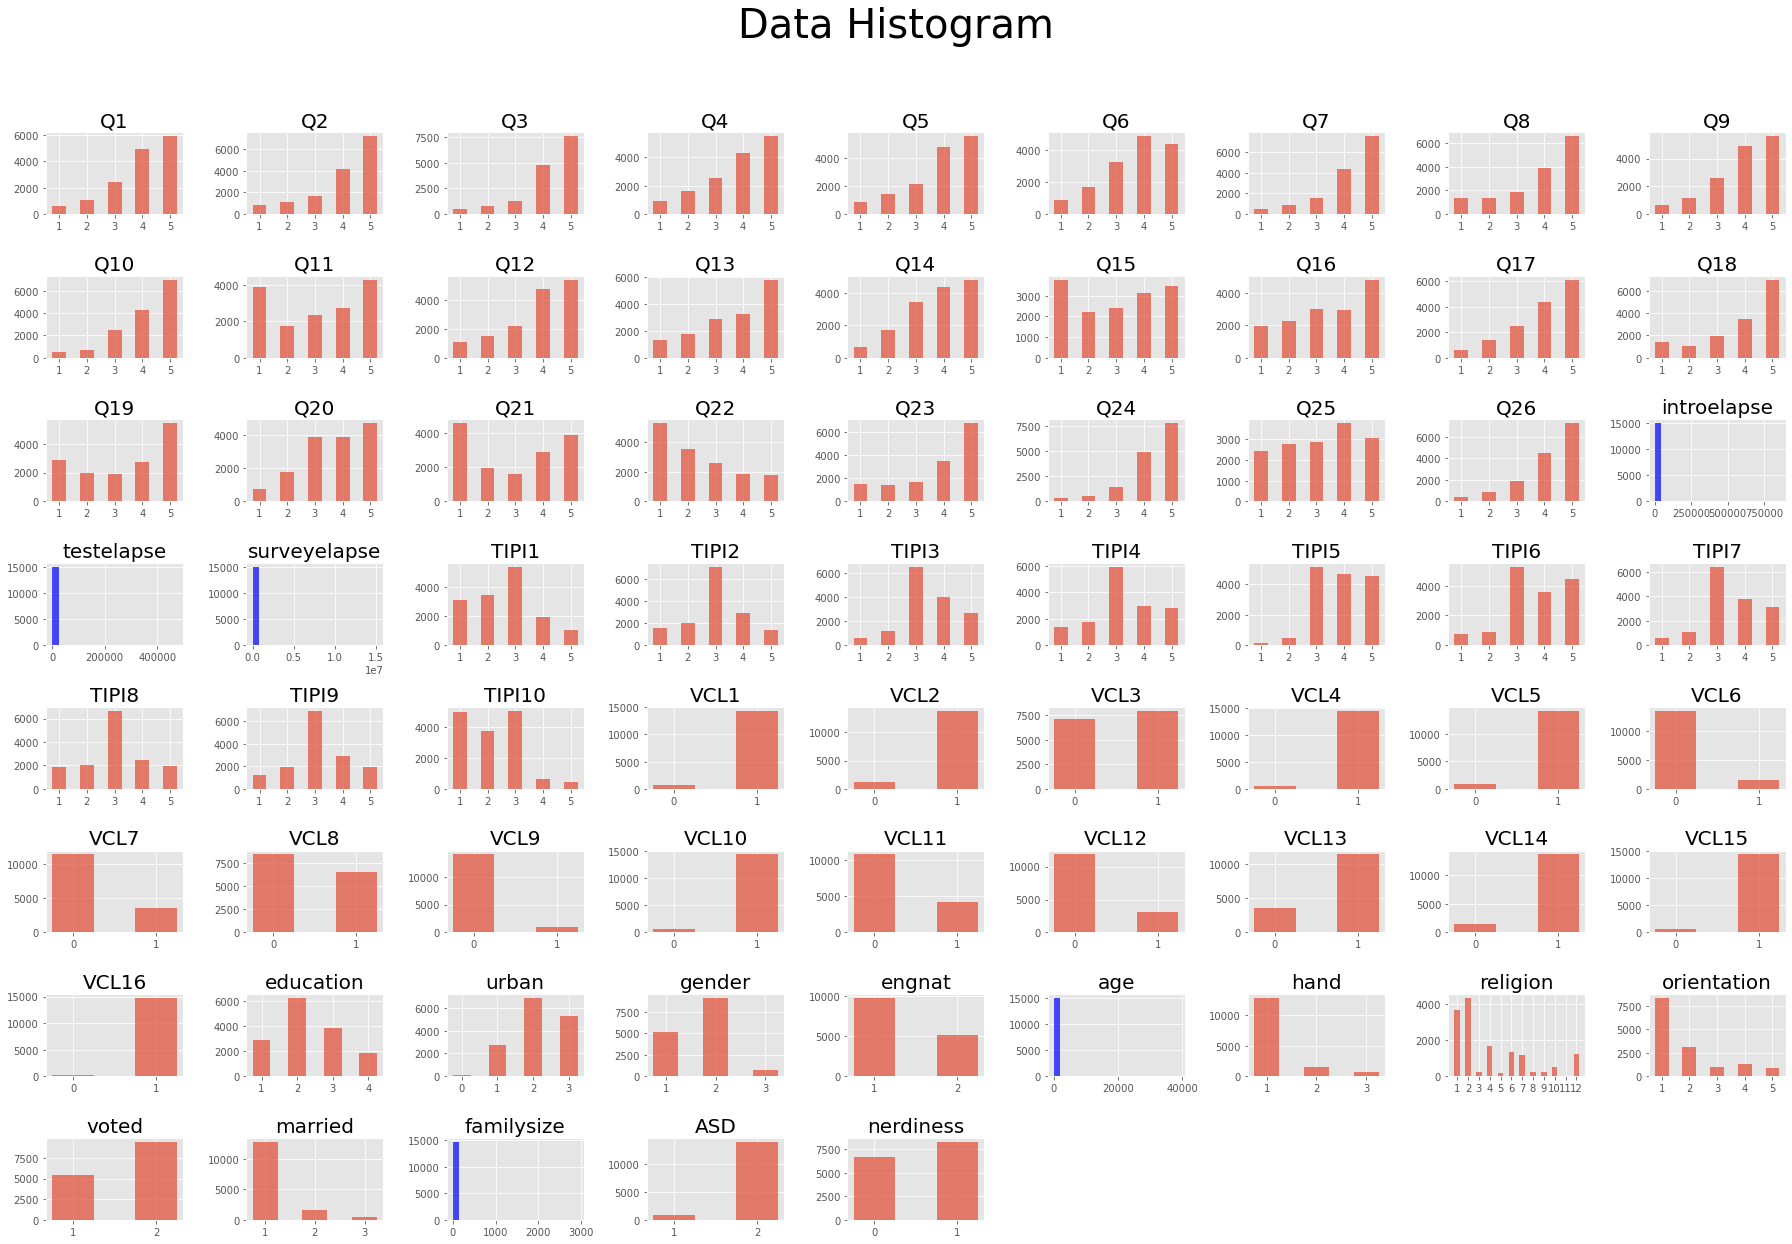

In [12]:
plt.style.use('ggplot')

# 히스토그램을 사용해서 데이터의 분포 살펴보기
plt.figure(figsize=(25, 20))
plt.suptitle("Data Histogram", fontsize = 40)

# id는 제외하고 시각화
cols = train.columns
for i in range(len(cols)):
    plt.subplot(9, 9, i+1) # 최대 5 by 5, 25개의 특징 분포를 확인할 수 있습니다.
    plt.title(cols[i], fontsize=20) # 각 분포그림의 제목을 특징명으로 설정합니다.
    if len(train[cols[i]].unique()) > 20: # 해당 특징의 고유한 값 종류가 20개가 넘으면
        plt.hist(train[cols[i]], bins=20, color='b', alpha=0.7) # 히스토그램을 출력합니다. bins는 칸을 나누는 값이며 alpha는 투명도입니다.
        
    else: # 해당 특징의 고유한 값 종류가 20개가 넘지 않으면
        temp = train[cols[i]].value_counts() # 각 특징의 값 종류의 개수들을 temp에 저장합니다.
        plt.bar(temp.keys(), temp.values, width=0.5, alpha=0.7)
        plt.xticks(temp.keys())
        
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

↑`introelapse` `testelapse` `surveyelapse` `age` `familysize` 특징의 히스토그램이 이상해보입니다. 예를들어 `age`의 x축이 40000까지 가는데 40000에 근사한 나이값이 기입이 된 것으로 보입니다. 매우 큰 이상치입니다.

## 이상치 & 결측치 평균값 대체
`저희는 이상치를 검출하여 이를 nan처리하고` 기존 nan값과 더불어 모든 nan값을 모두 Imputer을 통해 보간하였습니다.

## 이상치 확인
박스 플롯을 통해 이상치를 확인해봅니다. 박스플롯의 해석 방법은 아래와 같습니다.  

|구분|설명|
|------|:--------------------|
|whisker|상자의 좌우 또는 상하로 뻗어나간 선|
|박스 내부의 가로선|중앙값|
|lower<br>whisker|최소값<br>`중앙값 - 1.5 x IQR`보다 큰 데이터 중 가장 작은 값|
|upper<br>whisker|최대값<br>`중앙값 + 1.5 x IQR`보다 작은 데이터 중 가장 큰 값|
|IQR|Inter Quartile Range<br>실수값 `분포`에서의 제 3사분위수(Q3) - 제 1사분위수(Q1)
|점|이상치(outlier; 아웃라이어)<br>lower whisker보다 작은 데이터 또는 upper whisker보다 큰 데이터가 여기에 해당|

<AxesSubplot:>

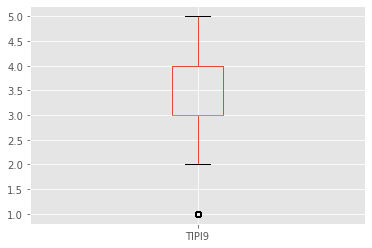

In [16]:
train['TIPI9'].plot(kind='box') # boxplot 설명을 위한 예시입니다.

↓모든 컬럼에 대해 boxplot을 출력해 봅니다. 매개변수 지정으로 쉽게 볼 수 있습니다.

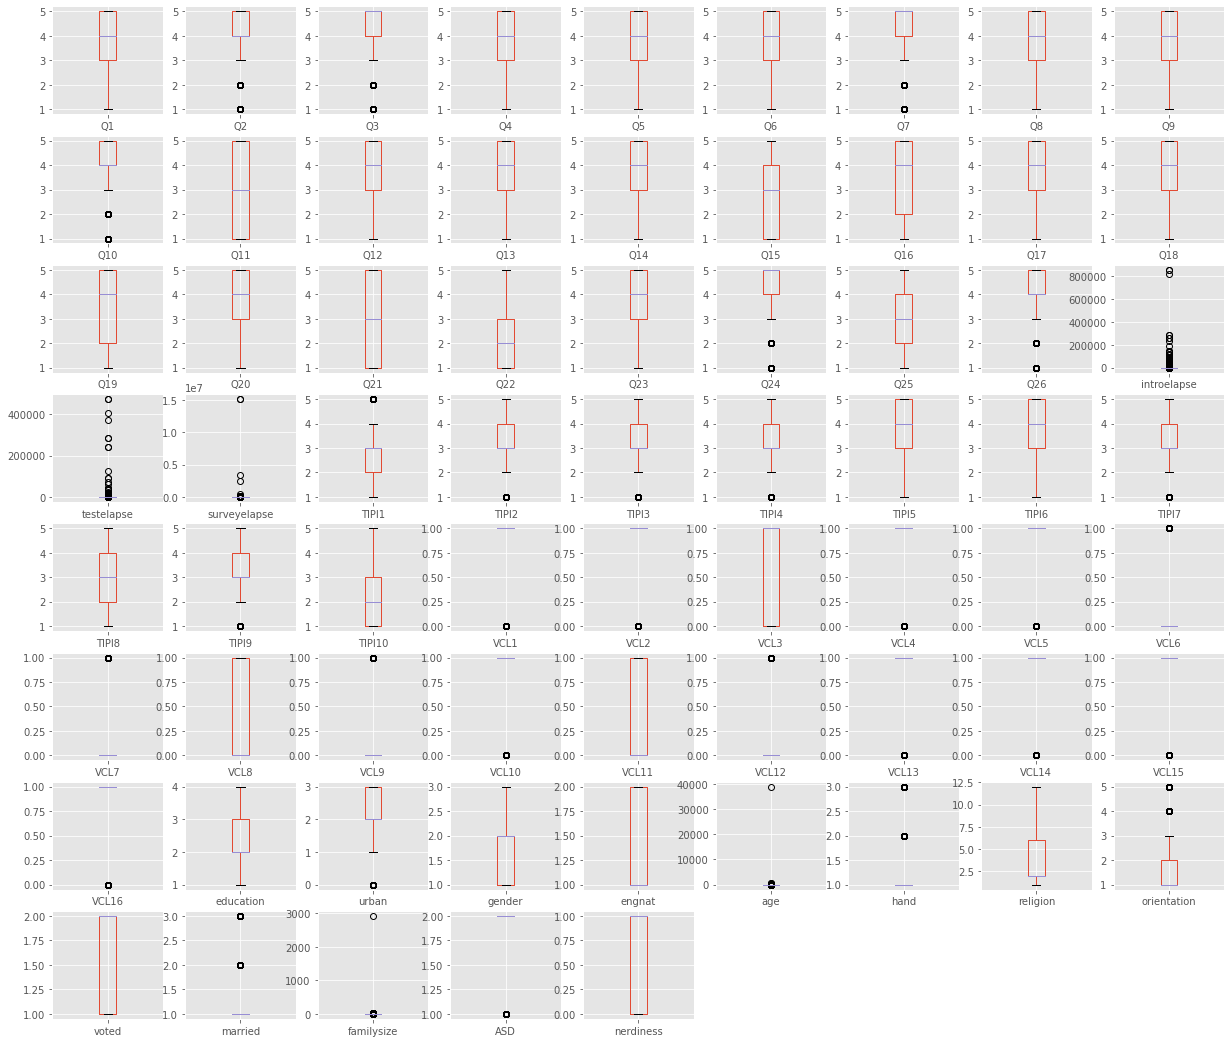

In [17]:
train.plot(kind='box', subplots=True, layout=(9, 9), figsize=(21, 21))
plt.show()       

↑위에서 본 대로 `introelapse` `testelapse` `surveyelapse` `age` `familysize`등등 컬럼의 박스플롯에서 박스가 보이질 않습니다. 심한 outlier가 존재한다는 의미입니다. 반드시 처리해야할 필요가 있습니다.

## 이상치 처리

In [18]:
def outliers_iqr(data):
    q1, q3 = np.percentile(data, [25, 75])
    # 넘파이의 값을 퍼센트로 표시해주는 함수

    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    
    return np.where((data > upper_bound) | (data < lower_bound))

↑위 함수는 이상치의 기준인 q1~q3 분포 범위 밖에있는 데이터의 인덱스 번호를 반환합니다.

In [24]:
introelapse_index_data = outliers_iqr(train['introelapse'])[0]
testelapse_index_data = outliers_iqr(train['testelapse'])[0]
surveyelapse_index_data = outliers_iqr(train['surveyelapse'])[0]
age_index_data = outliers_iqr(train['age'])[0]

↑이상치의 인덱스를 추출합니다.

In [25]:
train.loc[train['familysize'] > 5, 'familysize'] = np.nan # 6명 이상의 가족 수 == 이상치 처리, 왠지모르겠는데 위의 함수로 처리가 안됨.
train['familysize'].value_counts()

2.000000    6303
3.000000    3573
1.000000    2373
4.000000    1445
2.400239     771
5.000000     535
Name: familysize, dtype: int64

↑familysize의 경우 6명 이상을 이상치로 간주했습니다

In [26]:
train.loc[introelapse_index_data, 'introelapse'] = np.nan
train.loc[testelapse_index_data, 'testelapse'] = np.nan
train.loc[surveyelapse_index_data, 'surveyelapse'] = np.nan
train.loc[age_index_data, 'age'] = np.nan

↑이상치를 nan처리 해줍니다. 이제, 결측치와 이상치를 동일하게 처리합니다.

In [27]:
#test셋 적용
introelapse_index_data = outliers_iqr(test['introelapse'])[0]
testelapse_index_data = outliers_iqr(test['testelapse'])[0]
surveyelapse_index_data = outliers_iqr(test['surveyelapse'])[0]
age_index_data = outliers_iqr(test['age'])[0]
test.loc[test['familysize'] > 5, 'familysize'] = np.nan # 6명 이상의 가족 수 == 이상치 처리, 왠지모르겠는데 위의 함수로 처리가 안됨.
test['familysize'].value_counts()

test.loc[introelapse_index_data, 'introelapse'] = np.nan
test.loc[testelapse_index_data, 'testelapse'] = np.nan
test.loc[surveyelapse_index_data, 'surveyelapse'] = np.nan
test.loc[age_index_data, 'age'] = np.nan

In [28]:
from sklearn.impute import SimpleImputer
fill=SimpleImputer(missing_values=np.nan , strategy='mean')
train = pd.DataFrame(fill.fit_transform(train), columns = train.columns)
test = pd.DataFrame(fill.fit_transform(test), columns = test.columns)

↑sklearn의 impute모듈을 사용하면 아주 쉽게 데이터를 보간할 수 있습니다. Imputer는 missing_values로, 어떤 값을 빈 데이터로 간주할 것인지, strategy로 해당 값을 어떤 값으로 대체할 것인지, 축을 어디로 둘것인지를 정해 객체를 만들고,

fit을 사용하여 각 특징별 평균값을 구합니다.

이후 transform을 사용하여 값을 대체한 새로운 데이터프레임을 반환합니다.
 

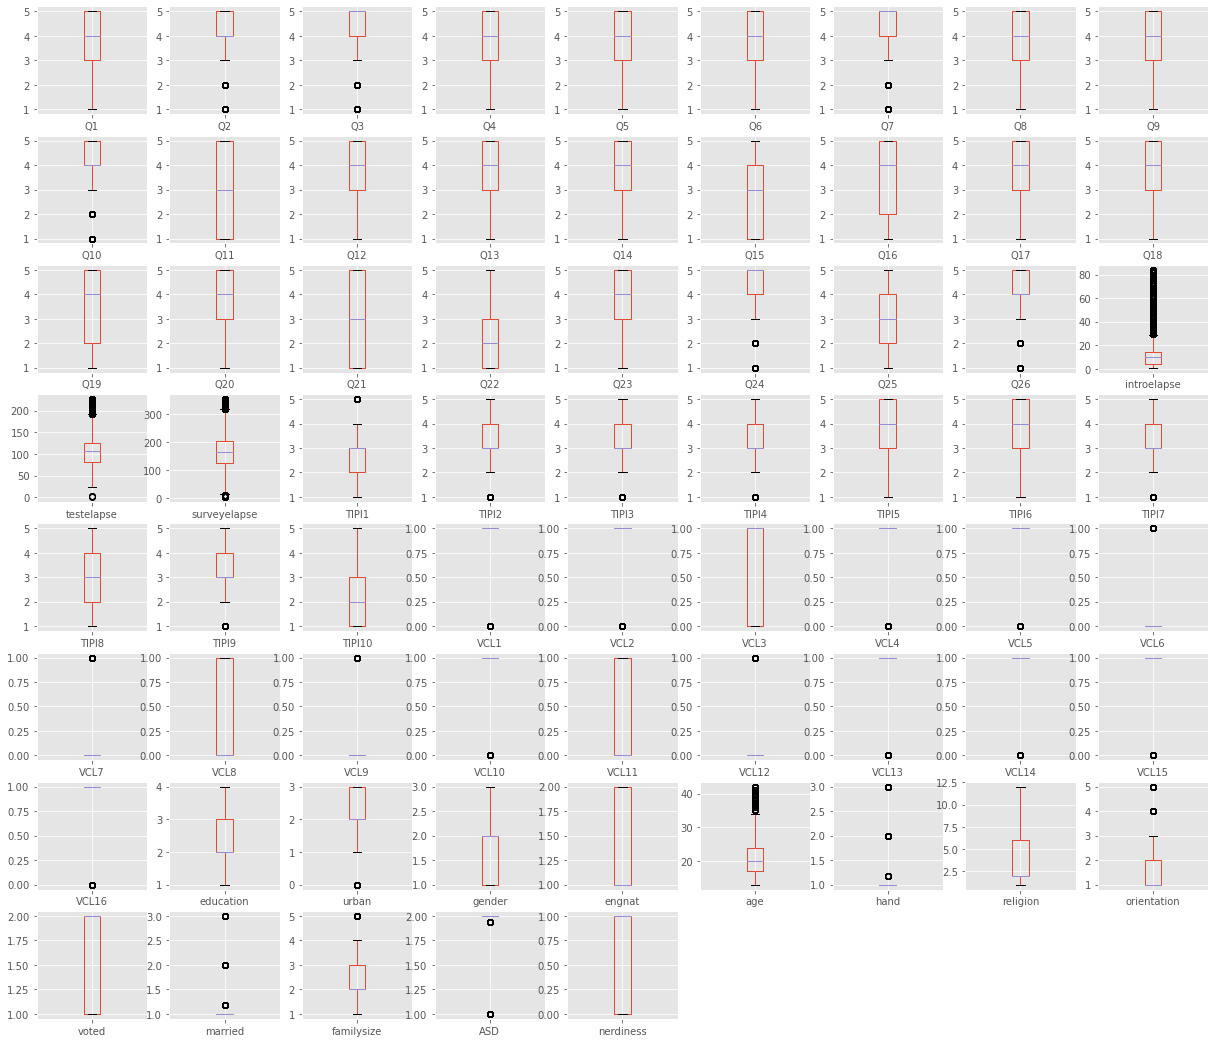

In [29]:
train.plot(kind='box', subplots=True, layout=(9, 9), figsize=(21, 21))
plt.show()

↑ 이상치의 분포가 완화된 모습입니다.

## 모델의 상관계수 확인 (성능에 큰 영향을 미치는 Question만 시각화)
모델의 큰 영향을 미치는 질문들만 시각화를 해보았습니다. 전체 컬럼에 대한 시각화는 링크에서 EDA 파일을 보시면 될 것 같습니다. <br>
nerdiness 모두 양의 상관관계를 가지는 것을 보아 질문지에 대해 어느정도 전처리가 된 것을 예측할 수 있습니다.

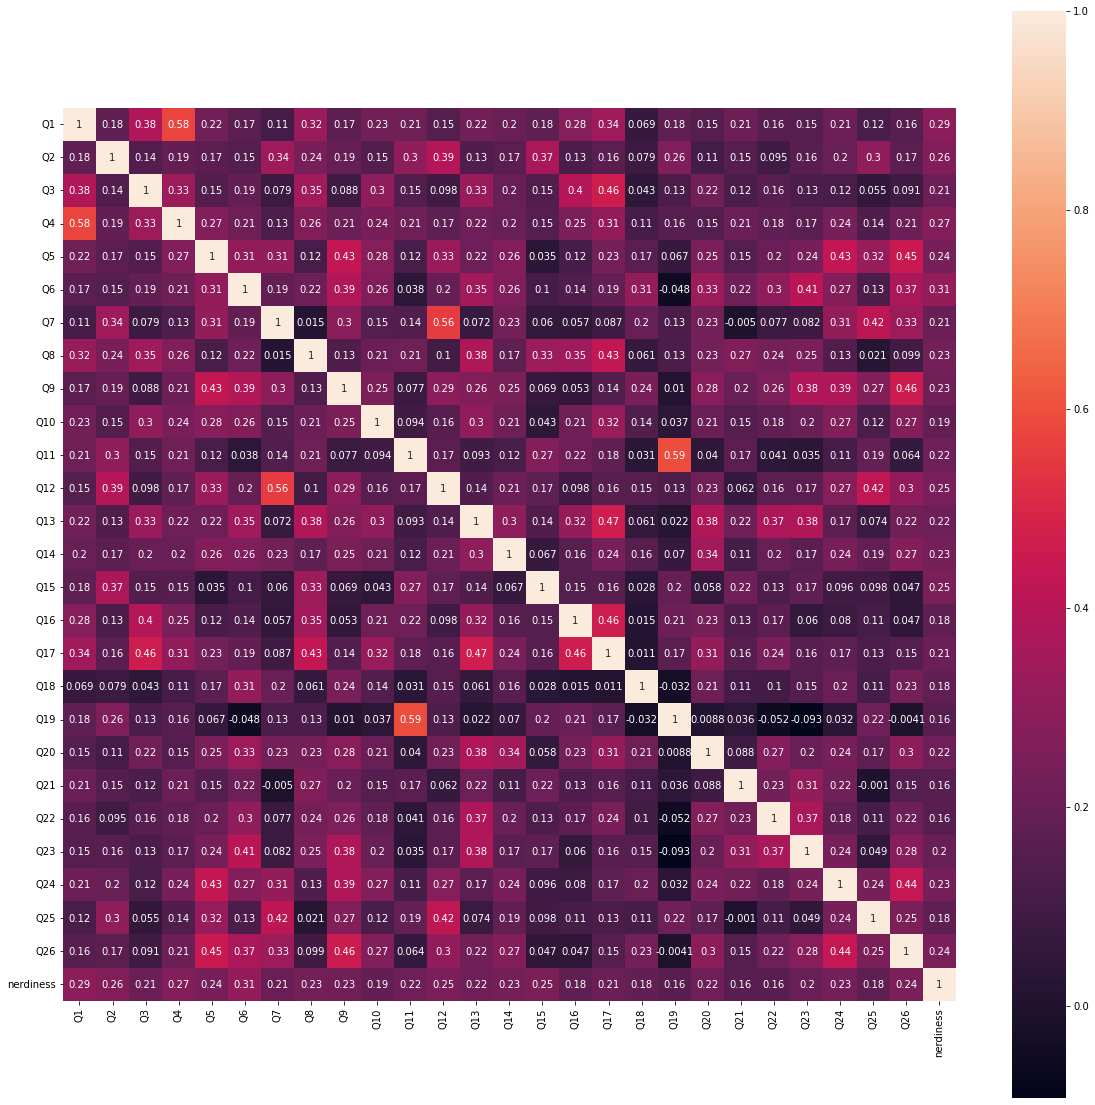

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.subplots(figsize=(20,20))
sns.heatmap(train[list_Questions].corr(), mask=np.zeros_like(train[list_Questions].corr(), dtype=bool),
            square=True, annot=True)
plt.show()

# 모델 탐색
어떤 모델이 좋을지는 돌려봐야 확실하게 알 수 있습니다. 여러 개의 모델을 통과한 결과를 얻고 어떤 모델을 사용할지 추려보고자 합니다. 데이터 편향을 방지하기 위해 k-fold를 이용하여 성능을 평가합니다.

In [31]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn import metrics

In [32]:
from sklearn.model_selection import StratifiedKFold


def kfold(model, train, ensemble = False):
    cv_accuracy = []
    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    
    n_iter = 0
    
    for t, v in cv.split(train, train['nerdiness']):
        
        train_cv = train.iloc[t] # 훈련용
        val_cv = train.iloc[v] # 검증용 분리

        train_X = train_cv.drop('nerdiness', axis=1)
        train_y = train_cv['nerdiness']

        val_X = val_cv.drop('nerdiness', axis=1)
        val_y = val_cv['nerdiness']

        model.fit(train_X, train_y)
        fpr, tpr, thresholds = metrics.roc_curve(val_y, model.predict_proba(val_X)[:, 1])

        score = metrics.auc(fpr, tpr)
        
        cv_accuracy.append(score)
        n_iter += 1
    return np.mean(cv_accuracy)

↑K-fold를 이용한 성능 측정 함수입니다. 5번의 분할을 번갈아 진행하며 평균을 내어 최종 성능을 비교합니다.<br>
모델 튜닝은 n_estimators의 숫자를 바꿔보며 진행하였습니다. <br>
모델 튜닝 코드는 길어져서 따로 올린 깃허브 링크를 참조하시면 될 것 같습니다. <br>
[링크](https://github.com/younghoonNa/Dacon_Prediction-of-Machiavellian-Tendency)

In [33]:
models = [
    RandomForestClassifier(n_estimators = 1000), # 0.8754887429218605
    LGBMClassifier(n_estimators = 4400),
    ExtraTreesClassifier(n_estimators = 1000),
    CatBoostClassifier(silent=True, n_estimators=1000)
]
for model in models:
    print(f'{type(model).__name__} score: {kfold(model, train)}')

''' 기존
models = [
    RandomForestClassifier(n_estimators=1000),
    LGBMClassifier(n_estimators=4400),
    ExtraTreesClassifier(n_estimators=1000),
    XGBClassifier(n_estimators=1000),
    CatBoostClassifier(n_estimators=1000, silent=True)
]
RandomForestClassifier score: 0.8765536224442337
LGBMClassifier score: 0.8684514024472471
ExtraTreesClassifier score: 0.8797427830434508
XGBClassifier score: 0.8538266217270998
CatBoostClassifier score: 0.8345673289599886

'''
print()

RandomForestClassifier score: 0.8761455488974196
LGBMClassifier score: 0.8684514024472471
ExtraTreesClassifier score: 0.8794019709974539
CatBoostClassifier score: 0.8345673289599886



↑튜닝까지 진행해보았을 때, RandomForest, ExtraTree, LGBM 이 세가지 모델이 성능이 우수하게 나왔습니다. 이 세 가지 모델을 앙상블 하겠습니다.

In [35]:
from sklearn.model_selection import train_test_split
train_8, test_2 = train_test_split(train, stratify=train['nerdiness'])

↑앙상블 비율을 찾기 위해 train_test분할을 진행합니다.

In [36]:
full = True # full이 True면 전체데이터로 학습(test 최종 결과물을 제출할 경우)
            # full이 False면 자체 테스트를 위해 split한 코드로 진행합니다.
if full:
    rf = RandomForestClassifier(n_estimators=1000).fit(train.drop('nerdiness', axis = 1), train['nerdiness'])
    #xgb = XGBClassifier(n_estimators=1200).fit(train.drop('nerdiness', axis = 1), train['nerdiness'])
    lgbm = LGBMClassifier(n_estimators=4400).fit(train.drop('nerdiness', axis = 1), train['nerdiness'])
    et = ExtraTreesClassifier(n_estimators=1000).fit(train.drop('nerdiness', axis = 1), train['nerdiness'])
    #cat = CatBoostClassifier(silent=True, n_estimators=1000).fit(train.drop('nerdiness', axis = 1), train['nerdiness'])
else:
    rf = RandomForestClassifier(n_estimators=1000).fit(train_8.drop('nerdiness', axis = 1), train_8['nerdiness'])
    #xgb = XGBClassifier(n_estimators=1200).fit(train_8.drop('nerdiness', axis = 1), train_8['nerdiness'])
    lgbm = LGBMClassifier(n_estimators=4400).fit(train_8.drop('nerdiness', axis = 1), train_8['nerdiness'])
    et = ExtraTreesClassifier(n_estimators=1000).fit(train_8.drop('nerdiness', axis = 1), train_8['nerdiness'])
    #cat = CatBoostClassifier(silent=True).fit(train_8.drop('nerdiness', axis = 1), train_8['nerdiness'])

↑위의 n_estimators의 값은 100부터 10000까지 돌려가면서 가장 성능이 우수했던 값입니다.

In [103]:
from tqdm.auto import tqdm
scores = []
for et_r in tqdm(np.arange(0.0, 1.01, 0.01)):
    for rf_r in np.arange(0.0, 1.01, 0.01):
        for lgbm_r in np.arange(0.0, 1.01, 0.01):
                    if et_r+rf_r+lgbm_r == 1.0:
                        pred = et_pred*et_r + rf_pred*rf_r + lgbm_pred*lgbm_r
                        scores.append([[check_auc_ensemble(test_2, pred)], [et_r, rf_r, lgbm_r]])


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:03<00:00, 25.34it/s]


In [102]:
def check_auc_ensemble(test_2, pred):
    label = test_2['nerdiness']

    fpr, tpr, thresholds = metrics.roc_curve(label, pred)

    score = metrics.auc(fpr, tpr)
    return score

In [104]:
scores = pd.DataFrame(scores)
max_index = np.argmax(scores[0])
scores.loc[max_index]

0    [0.8787937122902006]
1       [0.56, 0.2, 0.24]
Name: 4065, dtype: object

설명을 위해 이 코드를 위로 올립니다. 위 코드는 앙상블 비율을 찾기 위해 0.01단위로 모든 경우의수를 파악해보는 아주 비효율적인 코드입니다. 반복횟수가 적기 때문에 별다른 알고리즘 없이 1차원으로 접근해보았습니다. 5번을 진행했을 때 모두 ET 64% : RF 26% : LGBM 10% 비율이 나왔습니다.

In [37]:
rf_pred = rf.predict_proba(test)[:, 1]
lgbm_pred = lgbm.predict_proba(test)[:, 1]
et_pred = et.predict_proba(test)[:, 1]
#cat_pred = cat.predict_proba(test)[:, 1]
#xgb_pred = xgb.predict_proba(test_2.drop('nerdiness', axis=1))[:, 1]

## ↑predict_proba를 사용하는 이유
AUC 커브는 이진분류기에서 TPR(true positive rate)와 FPR(false positive rate)를 사용하여 만들어진 ROC커브의 아랫면적을 의미합니다. TPR은 전체 양성 샘플 중 양성으로 예측된 비율을 의미하고, FPR은 전체 음성 샘플 중에 양성으로 잘못 예측된 것의 비율을 의미합니다. 정리하자면 TPR은 1에 가까울 수록, FPR은 0에 가까울 수록 좋습니다.

ROC곡선 기준 좌상단에 가까워 질 수록 면적이 넓어지기 때문에 성능이 좋습니다. 하지만 0과 1로 0.5기준으로 나누어 값을 주기 보다는 해당 예측값의 확률을 이용함으로써 곡선을 완만하고 비교적 정확하게 그릴 수 있습니다. 0과 1로 단정지으면 0.5와 가까운 값에 대해 오차가 많이 발생하게 됩니다. 따라서 확률값을 이용하여 면적을 보다 넓게 그릴 수 있기 때문에 predict_proba를 사용합니다. 실제로 스코어가 매우 크게 향상됩니다.

In [ ]:
submission = pd.read_csv('submission_08_01.csv')

In [108]:
submission['nerdiness'] = (et_pred*0.64 + rf_pred*0.2 + lgbm_pred*0.1)
submission

,index,nerdiness
0,0,0.073961
1,1,0.809979
2,2,0.862640
3,3,0.638491
4,4,0.954748
...,...,...
35447,35447,0.956496
35448,35448,0.724911
35449,35449,0.927510
35450,35450,0.062933


In [109]:
submission.to_csv("08_12_ET_RF_LGBM_가중앙상블_Q22Reverse.csv", index = False)